In [1]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import mne
import moabb
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from moabb.analysis.meta_analysis import compute_dataset_statistics, find_significant_differences
from copy import deepcopy
from functools import partial
from sklearn.decomposition import KernelPCA as KPCA
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC

from moabb.datasets import BNCI2014_001, Zhou2016, BNCI2014_004, Lee2019_MI, BNCI2015_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import MotorImagery

import pyriemann as pr
from pyriemann.embedding import LocallyLinearEmbedding, _check_dimensions
from pyriemann.classification import SVC as RSVC
from pyriemann.estimation import Covariances
from pyriemann.utils.kernel import kernel_logeuclid, kernel_riemann
from helper import *

mne.set_log_level("CRITICAL")
moabb.set_log_level("info")
warnings.filterwarnings("ignore")

rs = 1337
FIG_WIDTH = 1000
FIG_HEIGHT = 500

To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


/Users/gabriel/repos/logkernelpaper/.venv/lib/python3.9/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


## Classification comparison

### Evaluation definition

In [2]:
MotorImageryClassification = deepcopy(MotorImagery)
MotorImageryClassification.scoring = 'accuracy'
paradigm = MotorImageryClassification(2)
paradigm.scoring = 'accuracy'

datasets = [
            BNCI2014_001(), 
            BNCI2014_004(), 
            BNCI2015_001(), 
            Lee2019_MI(), 
            Zhou2016()
            ]


evaluation = CrossSessionEvaluation

evaluation_params = {
    'paradigm': paradigm, 
    'datasets': datasets, 
    'random_state': rs,
    'overwrite': False, 
    'hdf5_path': './evaluation',
}

grid_search_params = {
    'cv': KFold(4), 
    'n_jobs': 8, 
}

linear_svc_params = {
    'dual': 'auto', 
    'max_iter': 10000
}

C_param = np.logspace(-4,4,9)
samples_mean = [10, 20, 40, 80, 100]
gle_gamma = np.logspace(-10,5,16)

kpca_components = [16, 32, 64, 128, 150, None]
lle_components = [16, 32, 64, 128, 150, None]
lle_neighbors = [16, 32, 64, 128, 150, None]


2024-04-24 10:59:33,131 WARNING MainThread moabb.paradigms.motor_imagery Choosing from all possible events


### RiemannSVC 

2024-04-23 09:15:39,975 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|                                                                                                 | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-23 09:15:40,539 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-004
BNCI2014-004-CrossSession:   0%|                                                                                                 | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-23 09:15:41,030 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2015-001
BNCI2015-001-CrossSession:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-23 09:15:41,519 INFO MainThread moabb.evaluations.base Processing dataset: Lee2019-MI
Lee2019-MI-CrossSession:   0%|                                                                                                  | 0/54 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-23 09:15:42,020 INFO MainThread moabb.evaluations.base Processing dataset: Zhou2016
Zhou2016-CrossSession:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-23 09:15:42,593 WARNING MainThread moabb.analysis.plotting Dataset names are too similar, turning off name shortening


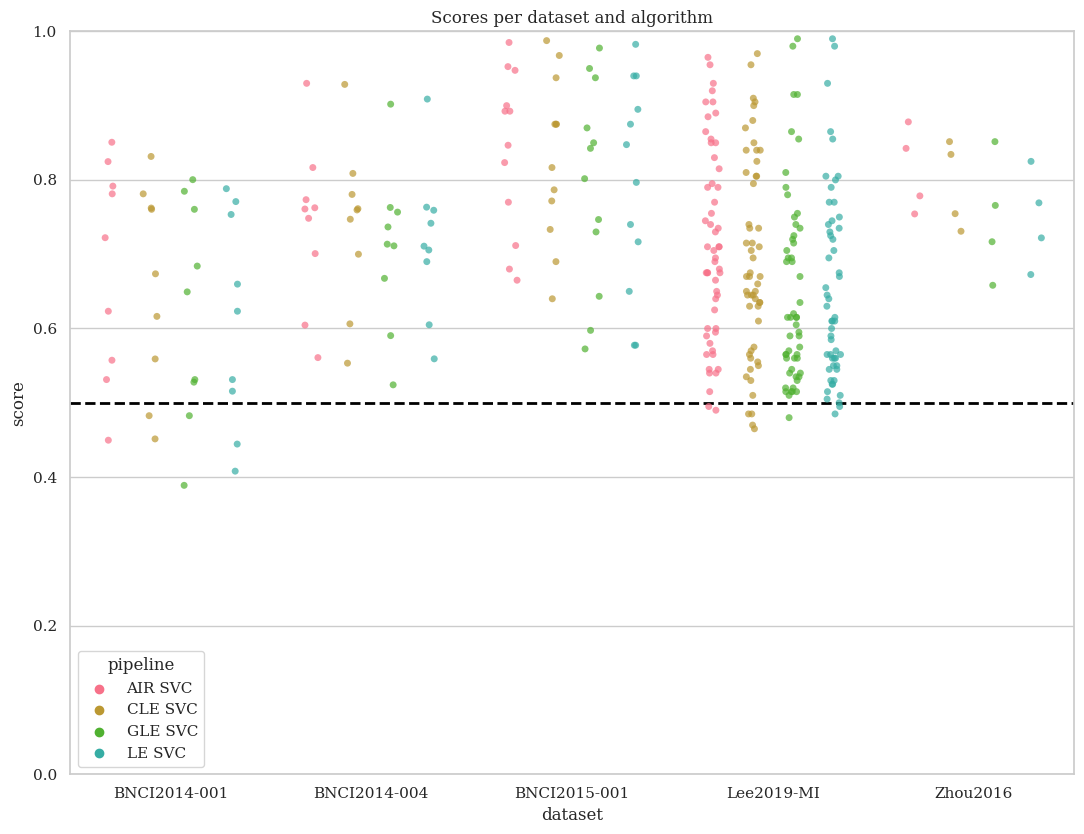

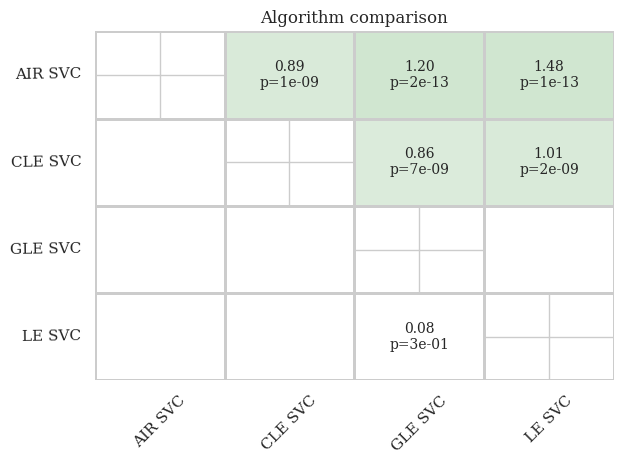

In [5]:
svc_evaluation = evaluation(**evaluation_params, suffix='svc')

svc_pipelines = {}

svc_pipeline_le = make_pipeline(Covariances(estimator="oas"), RSVC(metric='logeuclid'))
svc_pipeline_cle = make_pipeline(Covariances(estimator="oas"), RSVC(kernel_fct=kernel_cle_online))
svc_pipeline_rie = make_pipeline(Covariances(estimator="oas"), RSVC(kernel_fct=kernel_riemann_online))
svc_pipeline_gle = make_pipeline(Covariances(estimator="oas"), RSVC(kernel_fct=kernel_gle))

svc_params_le = {
    'svc__C':C_param,
}

svc_params_cle = {
    'svc__kernel_fct': [partial(kernel_cle_online, n_samples_mean=nm) for nm in samples_mean],
    'svc__C':C_param,
}

svc_params_rie = {
    'svc__kernel_fct': [partial(kernel_riemann_online, n_samples_mean=nm) for nm in samples_mean],
    'svc__C':C_param,
}

svc_params_gle = {
    'svc__kernel_fct': [partial(kernel_gle, gamma=nm) for nm in gle_gamma],
    'svc__C':C_param,
}

svc_pipelines["LE SVC"] = GridSearchCV(svc_pipeline_le, svc_params_le, **grid_search_params)
svc_pipelines["CLE SVC"] = GridSearchCV(svc_pipeline_cle, svc_params_cle, **grid_search_params)
svc_pipelines["AIR SVC"] = GridSearchCV(svc_pipeline_rie, svc_params_rie, **grid_search_params)
svc_pipelines["GLE SVC"] = GridSearchCV(svc_pipeline_gle, svc_params_gle, **grid_search_params)


results_svc = svc_evaluation.process(svc_pipelines)
moabb.analysis.analyze(results_svc, out_path=f'./results_svc', plot=True)

### LLE 

2024-04-25 10:02:26,005 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-25 10:02:26,542 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-004
BNCI2014-004-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-25 10:02:27,037 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2015-001
BNCI2015-001-CrossSession:   0%|          | 0/12 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-25 10:02:27,533 INFO MainThread moabb.evaluations.base Processing dataset: Lee2019-MI
Lee2019-MI-CrossSession:   0%|          | 0/54 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-25 10:02:28,035 INFO MainThread moabb.evaluations.base Processing dataset: Zhou2016
Zhou2016-CrossSession:   0%|          | 0/4 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-25 10:02:28,679 WARNING MainThread moabb.analysis.plotting Dataset names are too similar, turning off name shortening


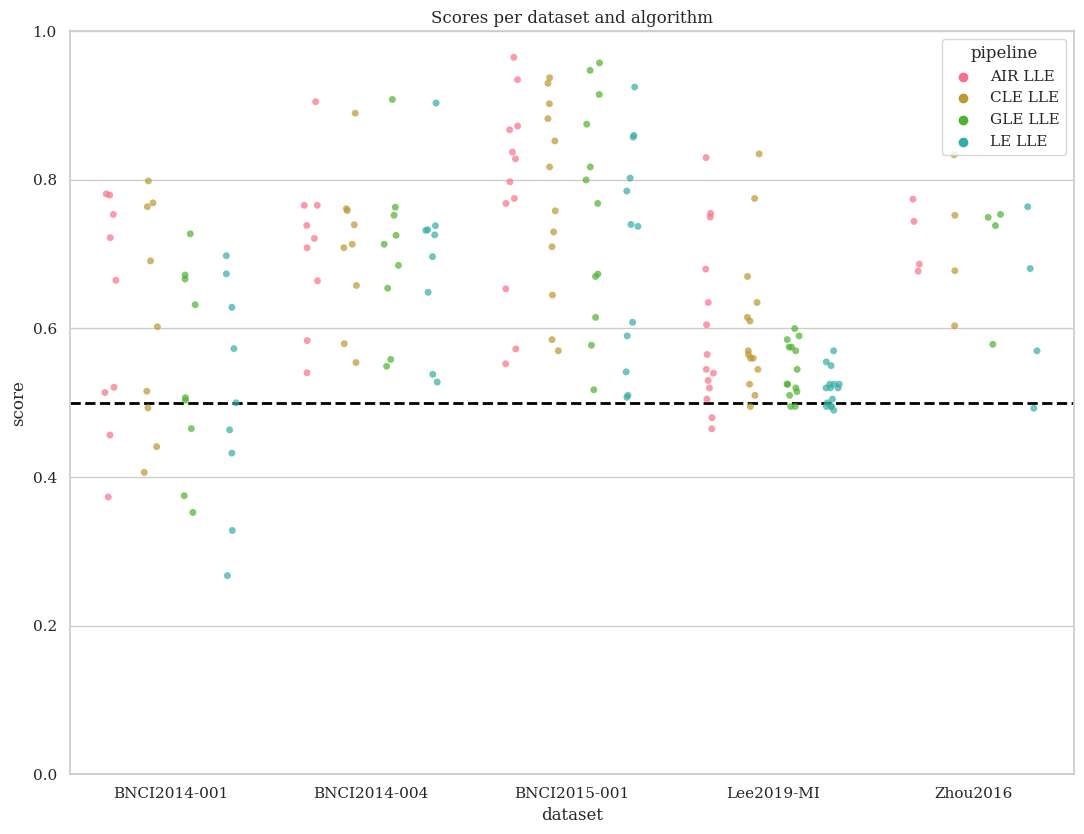

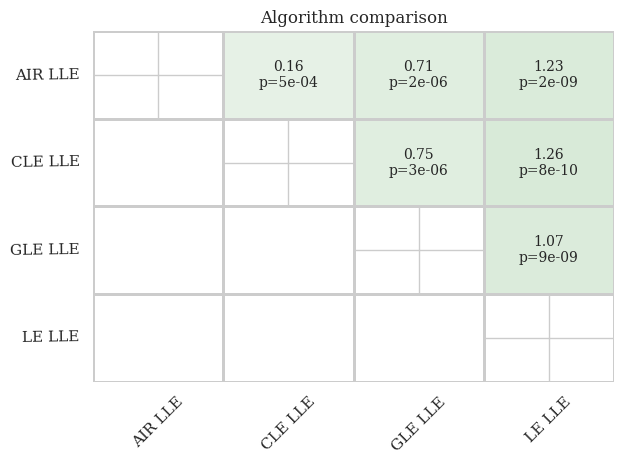

In [4]:
warnings.filterwarnings("ignore")

lle_evaluation = evaluation(**evaluation_params, suffix='lle')


lle_pipelines = {}
lle_pipeline_rie = make_pipeline(Covariances("oas"),
                                 LocallyLinearEmbedding(metric='riemann'), 
                                 LinearSVC(**linear_svc_params),
                                 )
lle_pipeline_cle = make_pipeline(Covariances("oas"), 
                                 LocallyLinearEmbedding(metric='logeuclid', 
                                                        kernel=kernel_cle),
                                 LinearSVC(**linear_svc_params),
                                 )
lle_pipeline_le = make_pipeline(Covariances("oas"), 
                                LocallyLinearEmbedding(metric='logeuclid'),
                                 LinearSVC(**linear_svc_params),
                                 )
lle_pipeline_gle = make_pipeline(Covariances("oas"), 
                                 LocallyLinearEmbedding(metric='logeuclid', 
                                                        kernel=partial(kernel_cle, gamma=0.00001)),
                                 LinearSVC(**linear_svc_params),
                                 )

params = [{
    'locallylinearembedding__n_components': lle_components,
    'locallylinearembedding__n_neighbors': lle_neighbors,
    'linearsvc__C': C_param
}
]

params_gle = [{
    'locallylinearembedding__n_components': lle_components,
    'locallylinearembedding__n_neighbors': lle_neighbors,
    'locallylinearembedding__kernel': [partial(kernel_gle, gamma=0.00001)],
    'linearsvc__C': C_param
}
]

lle_pipelines["LE LLE"] = GridSearchCV(lle_pipeline_le, params, **grid_search_params)
lle_pipelines["CLE LLE"] = GridSearchCV(lle_pipeline_cle, params, **grid_search_params)
lle_pipelines["GLE LLE"] = GridSearchCV(lle_pipeline_gle, params_gle, **grid_search_params)
lle_pipelines["AIR LLE"] = GridSearchCV(lle_pipeline_rie, params, **grid_search_params)


#plot_pipeline(llepipelines, evaluation)
results_lle = lle_evaluation.process(lle_pipelines)
moabb.analysis.analyze(results_lle, out_path=f'./results_lle', plot=True)

### KPCA

2024-04-22 10:33:31,550 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|                                                                                                 | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-22 10:33:32,136 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-004
BNCI2014-004-CrossSession:   0%|                                                                                                 | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-22 10:33:32,668 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2015-001
BNCI2015-001-CrossSession:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-22 10:33:33,198 INFO MainThread moabb.evaluations.base Processing dataset: Lee2019-MI
Lee2019-MI-CrossSession:   0%|                                                                                                  | 0/54 [00:00<?, ?it/s]

Subject 1 already processed



2024-04-22 10:33:33,722 INFO MainThread moabb.evaluations.base Processing dataset: Zhou2016
Zhou2016-CrossSession:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]/Users/gabriel/repos/logkernelpaper/.venv/lib/python3.9/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
/Users/gabriel/repos/logkernelpaper/.venv/lib/python3.9/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
/Users/gabriel/repos/logkernelpaper/.venv/lib/python3.9/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
/Users/gabriel/repos/logkernelpaper/.venv/lib/python3.9/site

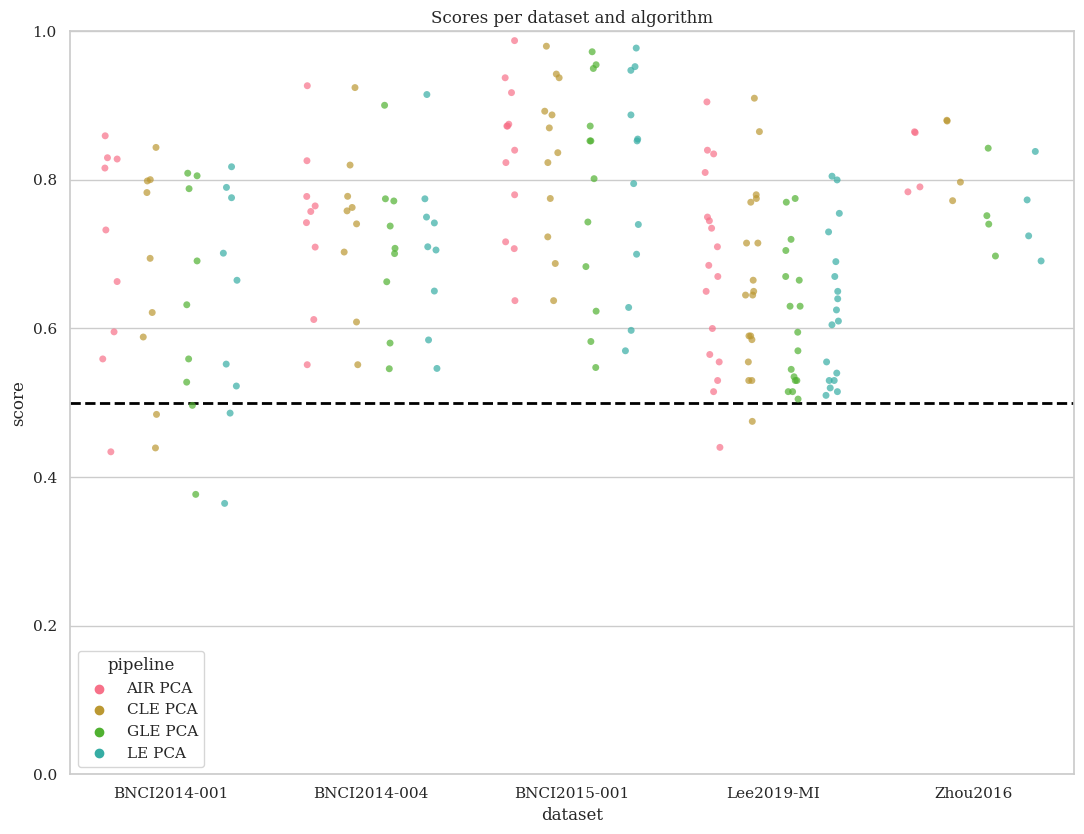

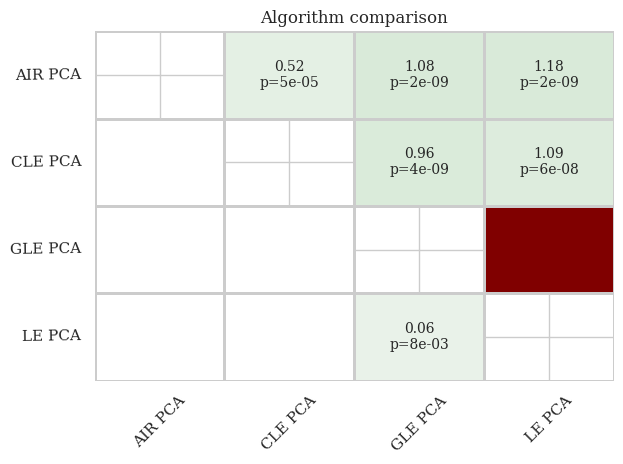

In [4]:
kpca_evaluation = evaluation(**evaluation_params, suffix='kpca')


kpca_pipelines = {}
kpca_pipeline_rie = make_pipeline(Covariances("oas"), 
                                  Gram(metric='riemann', kernel_fct=kernel_riemann_online), 
                                  KPCA(eigen_solver='dense', kernel='precomputed'), 
                                  LinearSVC(**linear_svc_params),
                                    )
kpca_pipeline_cle = make_pipeline(Covariances("oas"), 
                                  Gram(metric='cle', kernel_fct=kernel_cle_online), 
                                  KPCA(eigen_solver='dense', kernel='precomputed'), 
                                  LinearSVC(**linear_svc_params),
                                  )
kpca_pipeline_le = make_pipeline(Covariances("oas"), 
                                 Gram(metric='logeuclid', kernel_fct=kernel_logeuclid), 
                                 KPCA(eigen_solver='dense', kernel='precomputed'), 
                                 LinearSVC(**linear_svc_params),
                                 )
kpca_pipeline_gle = make_pipeline(Covariances("oas"), 
                                  Gram(metric='logeuclid', kernel_fct=kernel_gle), 
                                  KPCA(eigen_solver='dense', kernel='precomputed'), 
                                  LinearSVC(**linear_svc_params),
                             
                                )

kpca_params_le = [{
    'kernelpca__n_components': kpca_components,
    'linearsvc__C': C_param,
}
]

kpca_params_cle = [{
    'gram__kernel_fct': [kernel_cle_online],
    'gram__kernel_params': [{'n_samples_mean': i} for i in samples_mean],
    'kernelpca__n_components': kpca_components,
    'linearsvc__C': C_param,
}
]

kpca_params_rie = [{
    'gram__kernel_fct': [kernel_riemann_online],
    'gram__kernel_params': [{'n_samples_mean': i} for i in samples_mean],
    'kernelpca__n_components': kpca_components,
    'linearsvc__C': C_param,
}
]

kpca_params_gle = [{
    'gram__kernel_fct': [kernel_gle],
    'gram__kernel_params': [{'gamma': i} for i in gle_gamma],
    'kernelpca__n_components': kpca_components,
    'linearsvc__C': C_param,
}
]

kpca_pipelines["CLE PCA"] = GridSearchCV(kpca_pipeline_cle, kpca_params_cle, **grid_search_params)
kpca_pipelines["LE PCA"] = GridSearchCV(kpca_pipeline_le, kpca_params_le, **grid_search_params)
kpca_pipelines["AIR PCA"] = GridSearchCV(kpca_pipeline_rie, kpca_params_rie, **grid_search_params)
kpca_pipelines["GLE PCA"] = GridSearchCV(kpca_pipeline_gle, kpca_params_gle, **grid_search_params)

results_kpca = kpca_evaluation.process(kpca_pipelines)
moabb.analysis.analyze(results_kpca, out_path=f'./results_kpca', plot=True)

## Dimensionality Reduction scoring

In [8]:
def dim_red_scoring(estimator, X_test, y_test=None):
    return estimator.score(X_test)

MotorImageryDimRed = deepcopy(MotorImagery)
MotorImageryDimRed.scoring = dim_red_scoring
paradigm_dim_red = MotorImageryDimRed(2)
paradigm_dim_red.scoring = dim_red_scoring


evaluation_params_dim_red = {
    'paradigm': paradigm_dim_red, 
    'datasets': datasets, 
    'random_state': rs,
    'overwrite': False, 
    'hdf5_path': './evaluation',
}


lle_auc_gridsearch_params = {
    'cv': StratifiedKFold(5, shuffle=True, random_state=rs), 
    'n_jobs': 8, 
    'error_score': np.nan,
    'scoring': dim_red_scoring, 
    'refit': True, 
}


2024-04-11 11:28:17,114 WARNING MainThread moabb.paradigms.motor_imagery Choosing from all possible events


### KPCA

In [23]:
auc_kpca_evaluation = evaluation(**evaluation_params_dim_red, suffix='kpca_auc')
n_pca_components = 2

auc_kpca_pipelines = {}

auc_kpca_pipeline_air = make_pipeline(Covariances("oas"), 
                                      AUClnKWrapper(embedding=make_pipeline(
                                          Gram(metric='riemann', kernel=kernel_riemann), 
                                          KPCA(n_components=n_pca_components, kernel='precomputed')), 
                                        metric='riemann', n_jobs=8))

auc_kpca_pipeline_cle = make_pipeline(Covariances("oas"), 
                                      AUClnKWrapper(
                                          embedding=make_pipeline(
                                              Gram(metric='cle', kernel=kernel_cle), 
                                              KPCA(n_components=n_pca_components, kernel='precomputed')), 
                                        metric='cle', n_jobs=8))

auc_kpca_pipeline_le = make_pipeline(Covariances("oas"), 
                                     AUClnKWrapper(
                                         embedding=make_pipeline(
                                             Gram(metric='logeuclid', kernel=kernel_logeuclid), 
                                             KPCA(n_components=n_pca_components, kernel='precomputed')), 
                                        metric='logeuclid', n_jobs=8))

auc_kpca_pipeline_gle = make_pipeline(Covariances("oas"), 
                                      AUClnKWrapper(embedding=make_pipeline(
                                          Gram(metric='logeuclid', kernel=kernel_gle), 
                                          KPCA(n_components=n_pca_components, kernel='precomputed')), 
                                          metric='logeuclid'))

auc_kpca_params_gle = [{
    'auclnkwrapper__embedding__gram__kernel': [partial(kernel_gle, gamma=nm) for nm in gle_gamma[2:-5]],
}
]

auc_kpca_pipelines["AIR PCA"] = auc_kpca_pipeline_air

auc_kpca_pipelines["CLE PCA"] = auc_kpca_pipeline_cle

auc_kpca_pipelines["LE PCA"] = auc_kpca_pipeline_le
  
auc_kpca_pipelines["GLE PCA"] = GridSearchCV(auc_kpca_pipeline_gle, 
                                             auc_kpca_params_gle, 
                                             cv=2, 
                                             n_jobs=8)

#plot_pipeline(aucpipelines)
results_kpca_auc = auc_kpca_evaluation.process(auc_kpca_pipelines)
#moabb.analysis.analyze(results_kpca_auc, out_path=f'./results_kpca_auc', plot=True)

2024-01-25 11:09:08,243 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|                          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-01-25 11:09:08,866 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-004
BNCI2014-004-CrossSession:   0%|                          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-01-25 11:09:09,462 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2015-001
BNCI2015-001-CrossSession:   0%|                         | 0/12 [00:00<?, ?it/s]

Subject 1 already processed



2024-01-25 11:09:10,046 INFO MainThread moabb.evaluations.base Processing dataset: Lee2019-MI
Lee2019-MI-CrossSession:   0%|                           | 0/54 [00:00<?, ?it/s]

Subject 1 already processed



2024-01-25 11:09:10,636 INFO MainThread moabb.evaluations.base Processing dataset: Zhou2016
Zhou2016-CrossSession:   0%|                              | 0/4 [00:00<?, ?it/s]

Subject 1 already processed


### LLE

2024-01-25 11:09:14,482 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|                          | 0/9 [00:00<?, ?it/s]/Users/gabriel/miniforge3/envs/moabb310/lib/python3.10/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
/Users/gabriel/miniforge3/envs/moabb310/lib/python3.10/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
/Users/gabriel/miniforge3/envs/moabb310/lib/python3.10/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
/Users/gabriel/miniforge3/envs/moabb310/lib/python3.10/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflo

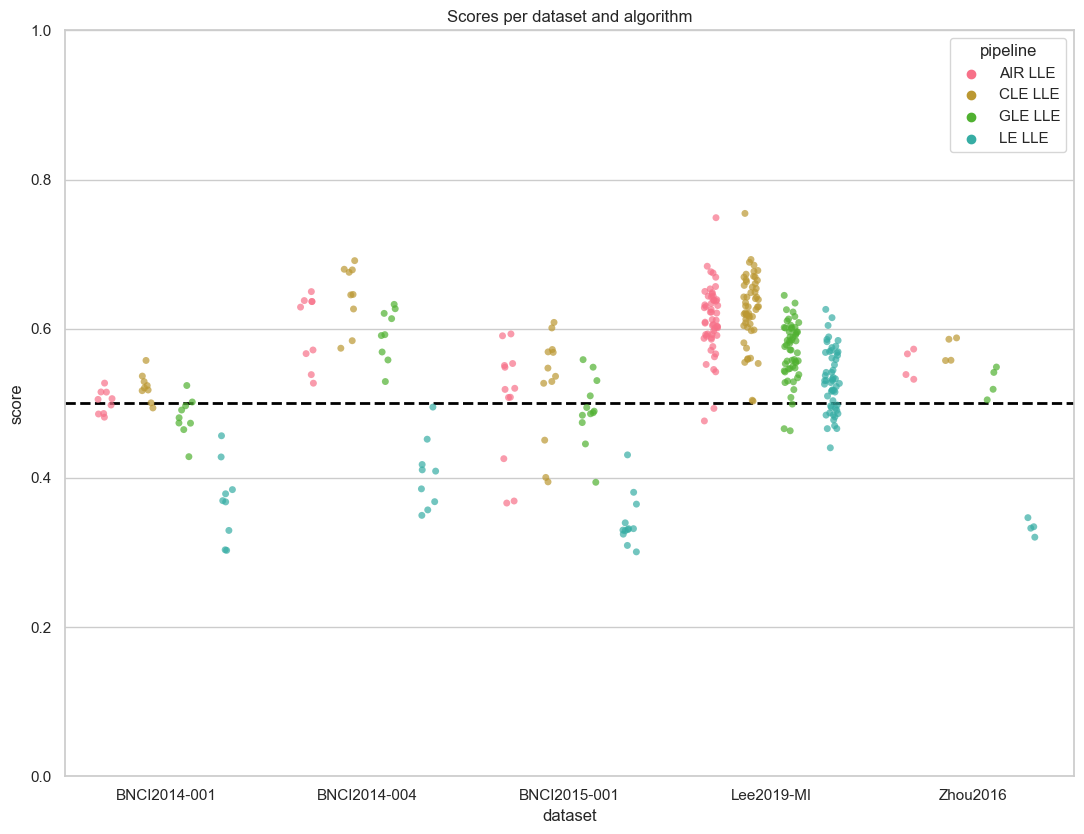

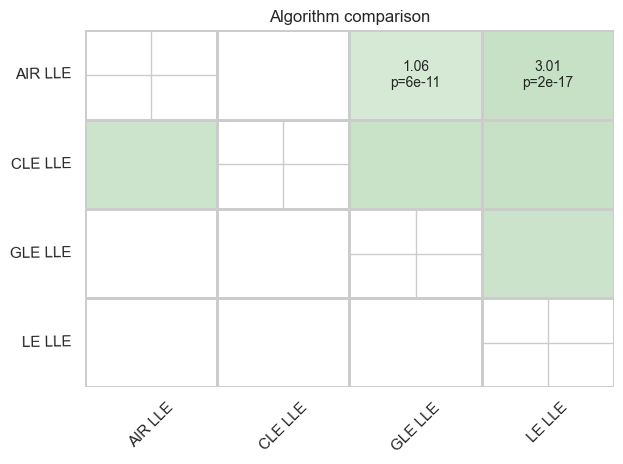

In [24]:
auc_lle_evaluation = evaluation(**evaluation_params_dim_red, suffix='lle_auc')

lle_pipelines_auc = {}
lle_pipeline_auc_rie = make_pipeline(Covariances("oas"), 
                                     AUClnKWrapper(embedding=LocallyLinearEmbedding(n_components=2, metric='riemann'), 
                                                   metric='riemann'))
lle_pipeline_auc_cle = make_pipeline(Covariances("oas"), 
                                     AUClnKWrapper(embedding=LocallyLinearEmbedding(n_components=2, metric='logeuclid', kernel_fct=kernel_cle), 
                                                   metric='cle'))
lle_pipeline_auc_le = make_pipeline(Covariances("oas"), 
                                    AUClnKWrapper(embedding=LocallyLinearEmbedding(n_components=2, metric='logeuclid'), 
                                                  metric='logeuclid'))
lle_pipeline_auc_gle = make_pipeline(Covariances("oas"), 
                                     AUClnKWrapper(embedding=LocallyLinearEmbedding(n_components=2, metric='logeuclid', kernel_fct=kernel_gle),
                                                   metric='logeuclid'))

lle_auc_params = [{
    'auclnkwrapper__embedding__n_neighbors': lle_neighbors,
}
]

lle_auc_params_gle = [{
    'auclnkwrapper__embedding__n_neighbors': lle_neighbors,
    'auclnkwrapper__embedding__kernel_fct': [partial(kernel_gle, gamma=nm) for nm in gle_gamma],
}
]

lle_pipelines_auc["LE LLE"] = GridSearchCV(lle_pipeline_auc_le, lle_auc_params, **lle_auc_gridsearch_params)
lle_pipelines_auc["CLE LLE"] = GridSearchCV(lle_pipeline_auc_cle, lle_auc_params, **lle_auc_gridsearch_params)
lle_pipelines_auc["AIR LLE"] = GridSearchCV(lle_pipeline_auc_rie, lle_auc_params, **lle_auc_gridsearch_params)
lle_pipelines_auc["GLE LLE"] = GridSearchCV(lle_pipeline_auc_gle, lle_auc_params_gle, **lle_auc_gridsearch_params)


#plot_pipeline(llepipelines, evaluation)
results_lle_auc = auc_lle_evaluation.process(lle_pipelines_auc)
moabb.analysis.analyze(results_lle_auc, out_path=f'./results_lle_auc', plot=True)

## Runtimes

### Gram

In [25]:
evaluation_params_runtime = {**evaluation_params}
evaluation_params_runtime['overwrite'] = True

gram_runtimes_evaluation = evaluation(**evaluation_params_runtime, suffix='gram_runtimes')

gram_runtimes_pipelines = {}
gram_runtimes_pipeline_rie = make_pipeline(pr.estimation.Covariances('cov'),
                                 pr.estimation.Shrinkage(),
                                 GramRuntimes(metric='riemann', kernel=pr.utils.kernel.kernel_riemann),
                                 DummyClassifier(),
                                 )
gram_runtimes_pipeline_cle = make_pipeline(pr.estimation.Covariances('cov'),
                                 pr.estimation.Shrinkage(),
                                 GramRuntimes(metric='logeuclid', kernel=kernel_cle),
                                 DummyClassifier(),
                                 )
gram_runtimes_pipeline_le = make_pipeline(pr.estimation.Covariances('cov'),
                                 pr.estimation.Shrinkage(), 
                                GramRuntimes(metric='logeuclid', kernel=pr.utils.kernel.kernel_logeuclid),
                                DummyClassifier(),
                                 )
gram_runtimes_pipeline_gle = make_pipeline(pr.estimation.Covariances('cov'),
                                 pr.estimation.Shrinkage(), 
                                 GramRuntimes(metric='logeuclid', kernel=kernel_gle),
                                 DummyClassifier(),
                                 )


gram_runtimes_pipelines["LE Gram"] = gram_runtimes_pipeline_le
gram_runtimes_pipelines["CLE Gram"] = gram_runtimes_pipeline_cle
gram_runtimes_pipelines["AIR Gram"] = gram_runtimes_pipeline_rie
gram_runtimes_pipelines["GLE Gram"] = gram_runtimes_pipeline_gle


#plot_pipeline(llepipelines, evaluation)
results_runtimes_gram = gram_runtimes_evaluation.process(gram_runtimes_pipelines)
moabb.analysis.analyze(results_runtimes_gram, out_path=f'./results_gram_runtime')

2024-01-25 22:08:33,108 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|                          | 0/9 [00:00<?, ?it/s]2024-01-25 22:08:35,299 INFO MainThread moabb.evaluations.base LE Gram | BNCI2014-001 | 1 | 0train: Score 0.250
2024-01-25 22:08:35,533 INFO MainThread moabb.evaluations.base LE Gram | BNCI2014-001 | 1 | 1test: Score 0.250
2024-01-25 22:08:35,811 INFO MainThread moabb.evaluations.base CLE Gram | BNCI2014-001 | 1 | 0train: Score 0.250
2024-01-25 22:08:36,080 INFO MainThread moabb.evaluations.base CLE Gram | BNCI2014-001 | 1 | 1test: Score 0.250
2024-01-25 22:08:36,566 INFO MainThread moabb.evaluations.base AIR Gram | BNCI2014-001 | 1 | 0train: Score 0.250
2024-01-25 22:08:37,074 INFO MainThread moabb.evaluations.base AIR Gram | BNCI2014-001 | 1 | 1test: Score 0.250
2024-01-25 22:08:37,345 INFO MainThread moabb.evaluations.base GLE Gram | BNCI2014-001 | 1 | 0train: Score 0.250
2024-01-25 22:08:37,598 INFO MainThrea

To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.
To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.
To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.
To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.
To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.
To use the get_shape_from_baseconcar, InputShapeSetterE

2024-01-25 22:13:34,457 INFO MainThread moabb.evaluations.base LE Gram | Lee2019-MI | 7 | 0: Score 0.500
2024-01-25 22:13:34,880 INFO MainThread moabb.evaluations.base LE Gram | Lee2019-MI | 7 | 1: Score 0.500
2024-01-25 22:13:35,371 INFO MainThread moabb.evaluations.base CLE Gram | Lee2019-MI | 7 | 0: Score 0.500
2024-01-25 22:13:35,847 INFO MainThread moabb.evaluations.base CLE Gram | Lee2019-MI | 7 | 1: Score 0.500
2024-01-25 22:13:37,167 INFO MainThread moabb.evaluations.base AIR Gram | Lee2019-MI | 7 | 0: Score 0.500
2024-01-25 22:13:38,526 INFO MainThread moabb.evaluations.base AIR Gram | Lee2019-MI | 7 | 1: Score 0.500
2024-01-25 22:13:38,928 INFO MainThread moabb.evaluations.base GLE Gram | Lee2019-MI | 7 | 0: Score 0.500
2024-01-25 22:13:39,348 INFO MainThread moabb.evaluations.base GLE Gram | Lee2019-MI | 7 | 1: Score 0.500
Lee2019-MI-CrossSession:  13%|██▍                | 7/54 [02:43<18:14, 23.28s/it]2024-01-25 22:13:57,704 INFO MainThread moabb.evaluations.base LE Gram | L

ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

# Plotting

## Set Parameters

In [15]:
paradigm_palette = 'CMRmap'
legend_title = 'Motor Imagery'
legend_loc = 'upper right'
fontsize1 = 56
fontsize2 = 42
fontsize3 = 30
fontsize4 = 22
fontsize5 = 18

legend_font = 14
legend_title_fontsize = 18
hue_order = [ 'AIR', 'CLE', 'GLE', 'LE']
dataset_order = ['2014-1', '2014-4', '2015-1', 'Lee2019', 'Zhou2016']

color_palette = 'Paired'
sns.set_style("whitegrid")

legend_title_auc = 'Kernel'
legend_title_scatter = 'Motor Imagery'

legend_params = {
    'fontsize': fontsize4,
    'title_fontsize': fontsize3,
    'bbox_to_anchor': (0, 1, 1, 0), 
    'loc': "lower left", 
    'borderaxespad': 0.1,
    'mode': "expand",
    'ncol':4,
    'handletextpad': 0.3

}

scatter_legend_params = {
   **legend_params,
    'ncol':3,
    'handletextpad': -0.6,
    
}

title_params = {
    'fontsize': fontsize3,
    'y':1.25, 
}

label_params = {
    'fontsize': fontsize3,
    'labelpad': fontsize4,
    'labelpad': 10,
}

tick_params = {
    'axis': 'both',
    'labelsize': fontsize4
}

head_text_params = {
    'x': 0.5, 
    'y': 1.5,
    'horizontalalignment': 'center',
    'verticalalignment': 'top',
    'fontsize': fontsize1
}

figure_counter_params = {
    'x': -0.1, 
    'y': 1.4,
    'horizontalalignment': 'left',
    'verticalalignment': 'top',
    'fontsize': fontsize2
}

subplot_adjust_params_dim_red = {
    'left': None,
    'right': None,
    'bottom': None,
    'top': None,
    'wspace': 0.25,
    'hspace': 0.7
}

subplot_adjust_params_classification = {
    'left':None, 
    'bottom':None, 
    'right':None, 
    'top':None, 
    'wspace':0.25, 
    'hspace':0.4
}

title_params_no_legend = {
    **title_params,
    'y':1.03, 
}

figure_counter_params_no_legend = {
    **figure_counter_params,
    'y':1.2, 
}

## Dimensionality Reduction plotting

### Calculate Scatter Embedding

In [16]:
X, y, metadata = MotorImagery().get_data(Zhou2016(), subjects=[2], return_epochs=True)

le = sklearn.preprocessing.LabelEncoder()
label = le.fit_transform(y)
covs = pr.estimation.Covariances(estimator='oas').fit_transform(X.get_data())

y[y=='feet'] = 'Feet'
y[y=='left_hand'] = 'Left Hand'
y[y=='right_hand'] = 'Right Hand'

neighs = len(X) - 1

lleembdcle = LocallyLinearEmbedding(n_neighbors=neighs, metric='cle').fit_transform(covs)
lleembdle = LocallyLinearEmbedding(n_neighbors=neighs, metric='logeuclid').fit_transform(covs)
lleembdrie = LocallyLinearEmbedding(n_neighbors=neighs, metric='riemann').fit_transform(covs)

lleembdgle = LocallyLinearEmbedding(n_neighbors=neighs, 
                                    metric='logeuclid', 
                                    kernel=partial(kernel_gle, gamma=.000001)).fit_transform(covs)


pcaembdle = make_pipeline(Gram(metric='logeuclid', kernel=pr.utils.kernel.kernel_logeuclid), KPCA(n_components=2, kernel='precomputed')).fit_transform(covs)
pcaembdrie = make_pipeline(Gram(metric='riemann', kernel=pr.utils.kernel.kernel_riemann), KPCA(n_components=2, kernel='precomputed')).fit_transform(covs)
pcaembdcle = make_pipeline(Gram(metric='cle', kernel=kernel_cle), KPCA(n_components=2, kernel='precomputed')).fit_transform(covs)
pcaembdgle = make_pipeline(Gram(metric='logeuclid', kernel=partial(kernel_gle, gamma=.000001)), KPCA(n_components=2, kernel='precomputed')).fit_transform(covs)



2024-04-11 12:03:48,563 WARNING MainThread moabb.paradigms.motor_imagery Choosing from all possible events


### Plot Dimensionality Reduction

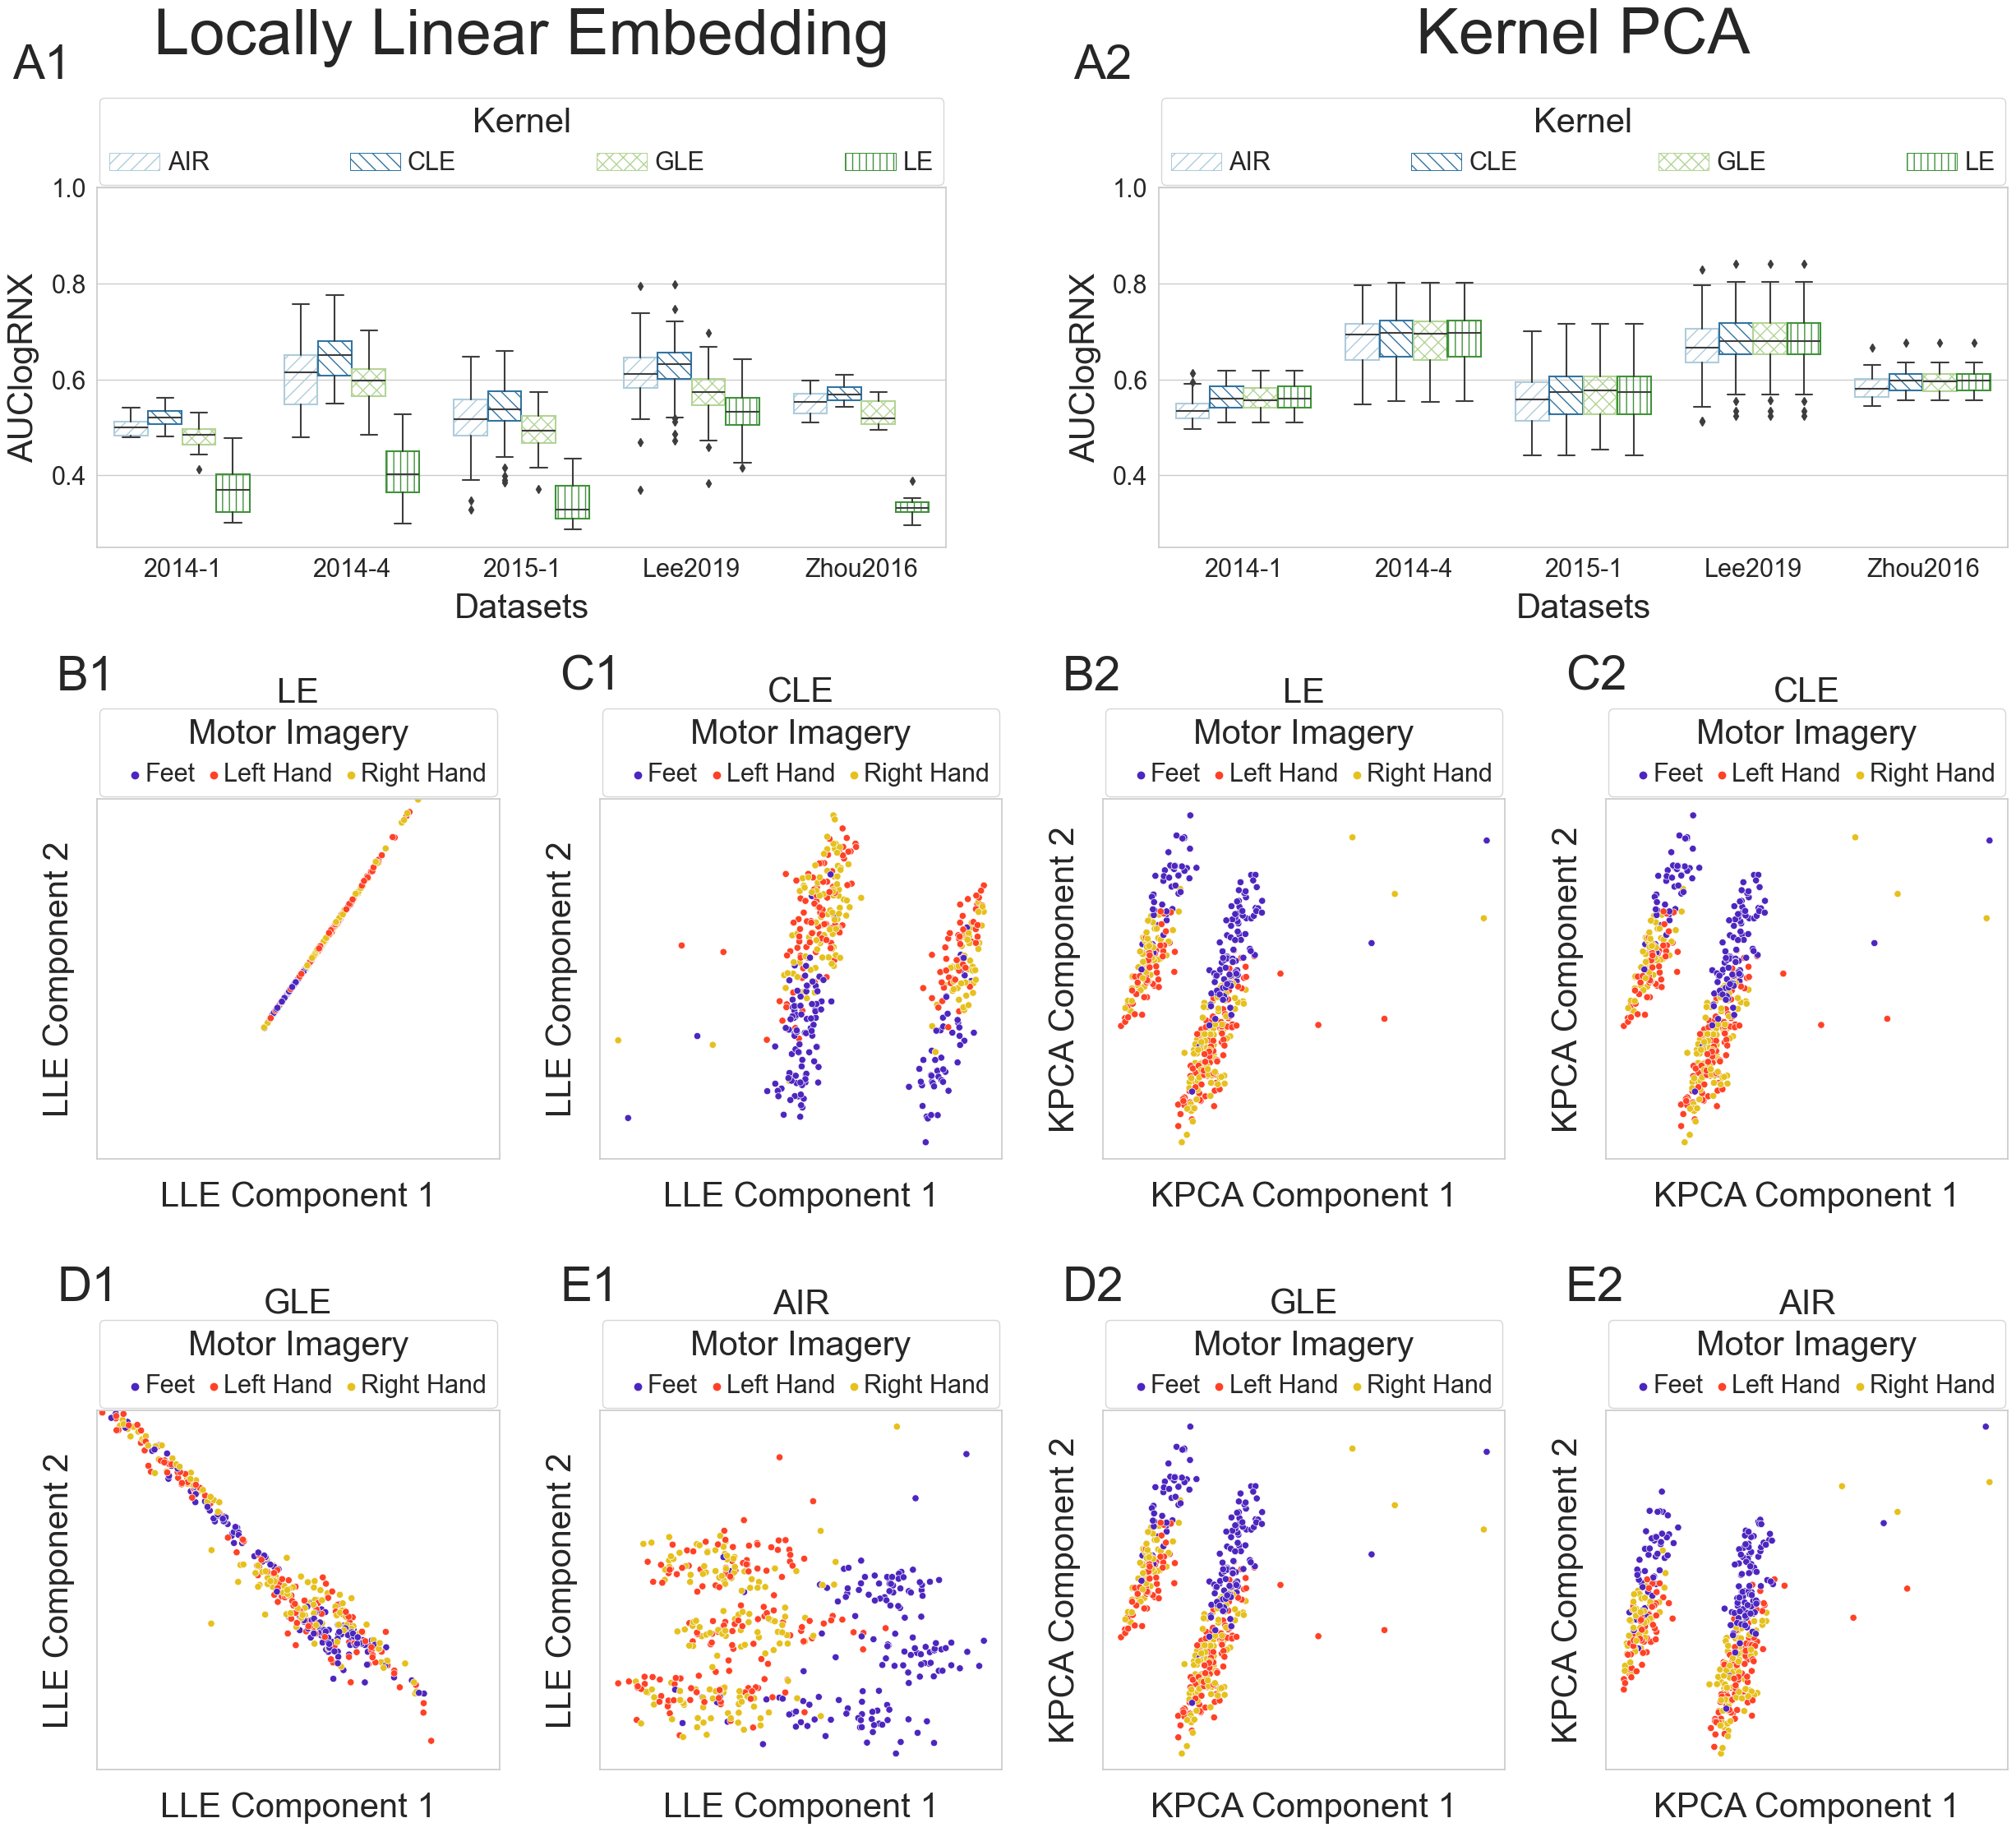

In [16]:
# Increase the figure size
fig = plt.figure(figsize=(30, 25))


start = 4
ax6= fig.add_subplot(3,2,1)
ax5= fig.add_subplot(3,2,2)

ax1= fig.add_subplot(3,4,start+1)
ax2= fig.add_subplot(3,4,start+2)
ax3= fig.add_subplot(3,4,start+3)
ax4= fig.add_subplot(3,4,start+4)

ax7= fig.add_subplot(3,4,start+5)
ax8= fig.add_subplot(3,4,start+6)
ax9= fig.add_subplot(3,4,start+7)
ax10= fig.add_subplot(3,4,start+8)

#first row text
plt.text(s='Kernel PCA', **head_text_params, transform = ax5.transAxes,)
plt.text(s='Locally Linear Embedding', **head_text_params, transform = ax6.transAxes)

#first row plots
auc_score_plots(ax5, './results_kpca_auc/analysis/data.csv', 'A2')
auc_score_plots(ax6, './results_lle_auc/analysis/data.csv', 'A1')

# scatterplots
scatterplots(ax2, lleembdcle, 'C1', 'CLE', 'LLE')
scatterplots(ax1, lleembdle, 'B1', 'LE', 'LLE', lim=[(-0.02, 0.02), (-0.02, 0.02)])
scatterplots(ax4, pcaembdcle, 'C2', 'CLE', 'KPCA')
scatterplots(ax3, pcaembdle, 'B2', 'LE', 'KPCA')

scatterplots(ax8, lleembdrie, 'E1', 'AIR', 'LLE')
scatterplots(ax7, lleembdgle, 'D1', 'GLE', 'LLE', lim=[(-0.02, 0.02), (-0.02, 0.02)])
scatterplots(ax10, pcaembdrie, 'E2', 'AIR', 'KPCA')
scatterplots(ax9, pcaembdgle, 'D2', 'GLE', 'KPCA')

fig.subplots_adjust(**subplot_adjust_params_dim_red)
#fig.tight_layout()
plt.savefig('embeddingresultszoomle.png', dpi=300, bbox_inches='tight')

## Classification Performance plotting

NameError: name 'head_text_params' is not defined

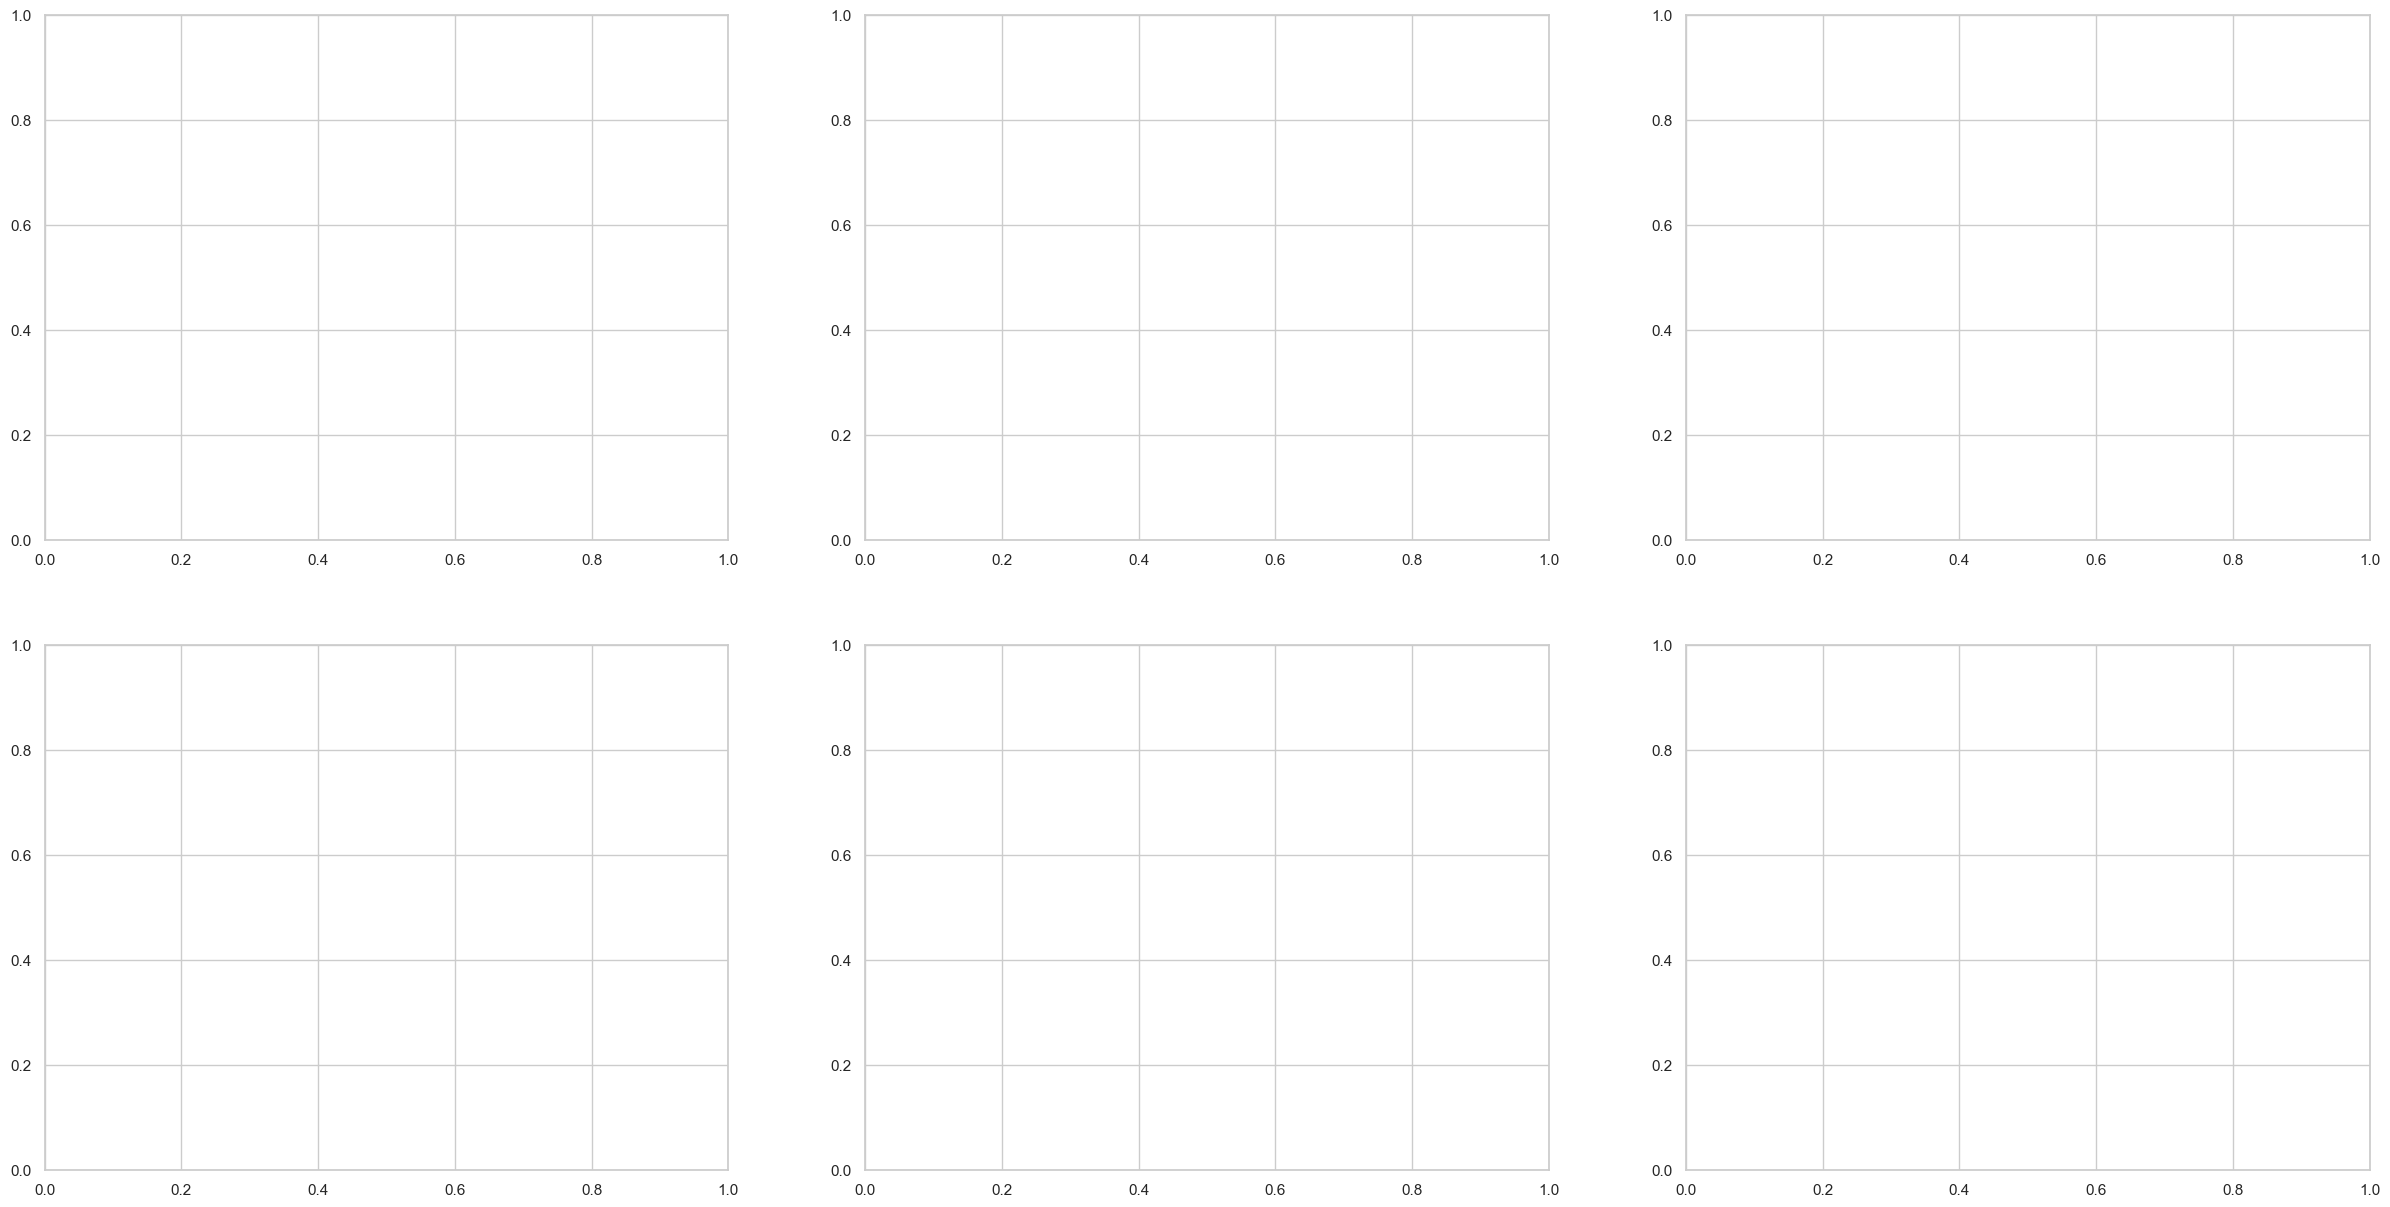

In [14]:
fig, axes = plt.subplots(2, 3, figsize = (30,15))

ax1, ax2, ax3, ax4, ax5, ax6 = axes[0,0], axes[0,1], axes[0,2], axes[1,0], axes[1,1], axes[1,2]

# USE PROPER FILE 
lledata=pd.read_csv('./results_lle/analysis/data.csv')
lledata = clean_dataset_strings(lledata)

kpcadata=pd.read_csv("./results_kpca/analysis/data.csv")
kpcadata = clean_dataset_strings(kpcadata)


svcdata=pd.read_csv("./results_svc/analysis/data.csv")
svcdata = clean_dataset_strings(svcdata)


#first row plots
accuracy_plot(ax1, lledata, 'LLE+LinearSVC', 'A1')
accuracy_plot(ax2, kpcadata, 'KPCA+LinearSVC', 'A2')
accuracy_plot(ax3, svcdata, 'RiemannSVC', 'A3')

# second row
stat_analysis_classification(ax4, lledata, 'B1')
stat_analysis_classification(ax5, kpcadata, 'B2')
stat_analysis_classification(ax6, svcdata, 'B3')
fig.subplots_adjust(**subplot_adjust_params_classification)
fig.tight_layout()
plt.savefig('classificarionresults.png', dpi=300, bbox_inches='tight')


In [ ]:

#resdf = svcdata.append([lledata, kpcadata]).groupby(['dataset', 'pipeline']).median()['score']
#print(resdf)



To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.
To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.
To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.
To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.
To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.
To use the get_shape_from_baseconcar, InputShapeSetterE

## Runtimes

     Unnamed: 0     score      time  samples  subject    session  channels  \
0             0  0.250000  0.693713    288.0        1  session_E        22   
1             1  0.250000  0.731731    288.0        1  session_T        22   
2             2  0.250000  0.734403    288.0        2  session_E        22   
3             3  0.250000  0.749655    288.0        2  session_T        22   
4             4  0.250000  0.769644    288.0        3  session_E        22   
..          ...       ...       ...      ...      ...        ...       ...   
839         839  0.337748  0.069963    300.0        3  session_1        14   
840         840  0.333333  0.093586    301.0        3  session_2        14   
841         841  0.333333  0.061219    300.0        4  session_0        14   
842         842  0.333333  0.100467    285.0        4  session_1        14   
843         843  0.333333  0.064111    285.0        4  session_2        14   

     n_sessions   dataset pipeline  
0             2    2014-1 

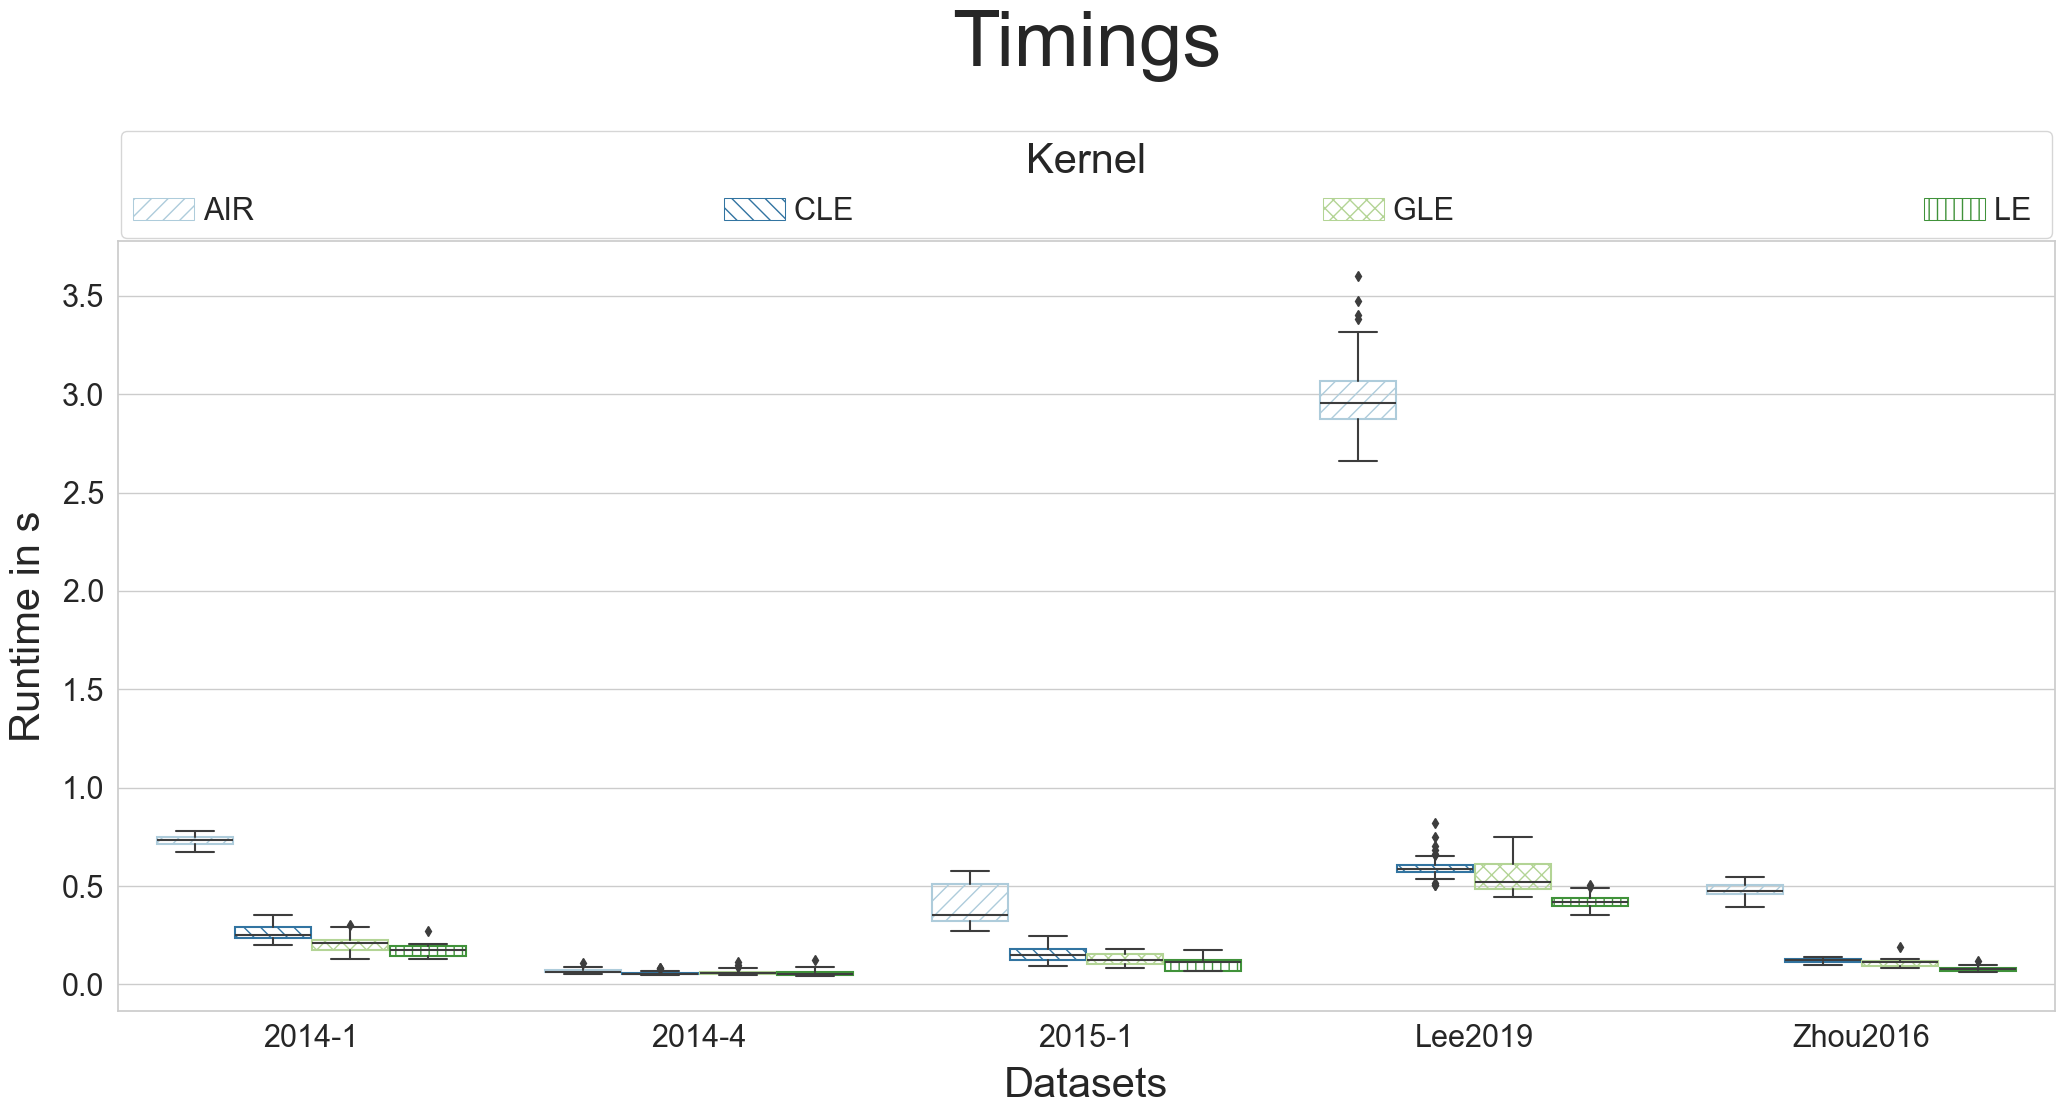

      AIR           CLE           GLE            LE 
AIR    NaN  1.243362e-17  1.674091e-16  4.444329e-17
CLE    1.0           NaN  1.077670e-09  9.830597e-14
GLE    1.0  1.000000e+00           NaN  5.385469e-14
LE     1.0  1.000000e+00  1.000000e+00           NaN


(<Figure size 2500x1000 with 1 Axes>,
 <Axes: title={'center': 'Algorithm comparison'}>)

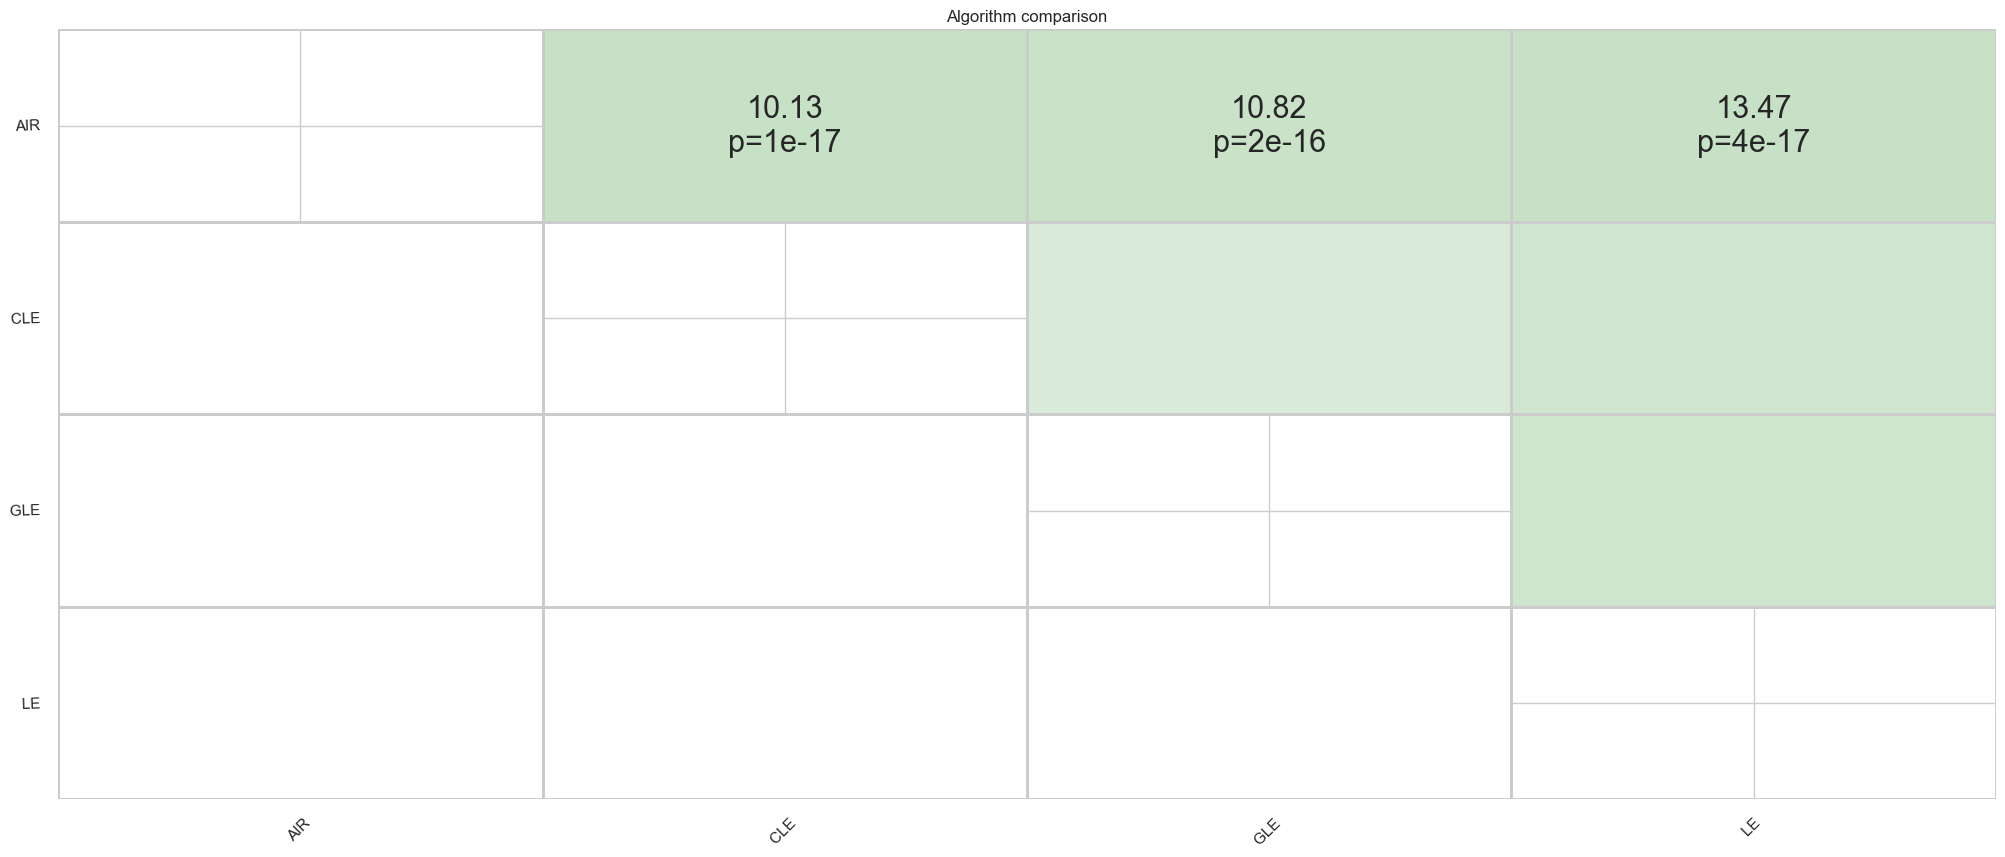

In [83]:
res_gram = pd.read_csv('./results_gram_runtime/analysis/data.csv')
res_gram = clean_dataset_strings(res_gram)

print(res_gram)
fig, axes = plt.subplots(1, 1, figsize = (25,10))

def timing_plot(ax, data_, title, fig_counter):
    headtextparams = {
        **head_text_params,
        'y': 1.3
    }
    plt.text(s=title, **headtextparams, transform = ax.transAxes,)
    bp1 = sns.boxplot(x="dataset", 
                      y="time", 
                      hue="pipeline", 
                      data=data_, 
                      palette='Paired', 
                      ax=ax,
                        order=dataset_order
                      #hue_order=hue_order,
                     )
    
    l1 = ax.legend(title=legend_title_auc, **legend_params)
    sethatches(bp1, l1)
    ax.set_ylabel('Runtime in s', **label_params)
    ax.set_xlabel('Datasets', **label_params)
    ax.tick_params(**tick_params)
    #ax.set_yscale('log')
    plt.text(s=fig_counter, transform = ax.transAxes, **figure_counter_params)


timing_plot(axes, res_gram, 'Timings', '')
plt.savefig('timingsgramnew.png', dpi=300)
plt.show()

#res_gram['time'] = -res_gram['time']
res_gram.rename(columns={"score": "time",
                                   'time': 'score'}, inplace=True)
fig, axes = plt.subplots(1, 1, figsize = (25,10))

stats = compute_dataset_statistics(res_gram)
sig_df, effect_df = find_significant_differences(stats)
print(sig_df)
summary_plot(sig_df,effect_df, ax=axes)